In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data = pd.read_csv(r"C:\Users\Kritika Singh\OneDrive\Desktop\tamizhan_Project\Sales Forecasting\monthly_sales.csv", parse_dates=['date'])
data.set_index('date', inplace=True)

In [3]:
# Feature Engineering: Creating a supervised learning problem
data['sales_diff'] = data['sales'].diff()
data.dropna(inplace=True)

In [4]:
def create_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [5]:
# Creating supervised data for the last 24 months
supervised_data = create_supervised(data['sales_diff'], 12)

In [6]:
# Splitting data into train and test sets
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]

In [7]:
print("Train data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)

Train data shape:  (912987, 13)
Test data shape:  (12, 13)


In [8]:
# Scaling features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [9]:
# Splitting data into input and output
x_train, y_train = train_data[:, 1:], train_data[:, 0]
x_test, y_test = test_data[:, 1:], test_data[:, 0]

In [10]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [11]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (912987, 12)
y_train shape:  (912987, 1)
x_test shape:  (12, 12)
y_test shape:  (12, 1)


In [12]:
# Creating a DataFrame to store predictions
sales_dates = data.index[-13:].to_series().reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates, columns=['date'])

In [13]:
# Actual sales for the last 13 months
actual_sales = data['sales'].values[-13:]


In [14]:
# Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_predict = lr_model.predict(x_test)

In [15]:

# Inverse transform to original scale
lr_predict = scaler.inverse_transform(np.concatenate((lr_predict, x_test), axis=1))[:, 0]

In [16]:
# Calculating predicted sales
result_list = []
for index in range(len(lr_predict)):
    result_list.append(lr_predict[index] + actual_sales[index])

lr_predict_series = pd.Series(result_list, name='linear_prediction')


In [17]:
# Merging with prediction DataFrame
predict_df = predict_df.join(lr_predict_series)

In [19]:
# Model Evaluation
lr_mse = np.sqrt(mean_squared_error(actual_sales[1:], lr_predict))
lr_mae = mean_absolute_error(actual_sales[1:], lr_predict)
lr_r2  = r2_score(actual_sales[1:], lr_predict)


In [20]:
print(f"Linear Regression MSE: {lr_mse}")
print(f"Linear Regression MAE: {lr_mae}")
print(f"Linear Regression R2 Score: {lr_r2}")

Linear Regression MSE: 64.36205415112437
Linear Regression MAE: 61.61447788172183
Linear Regression R2 Score: -29.629846372042422


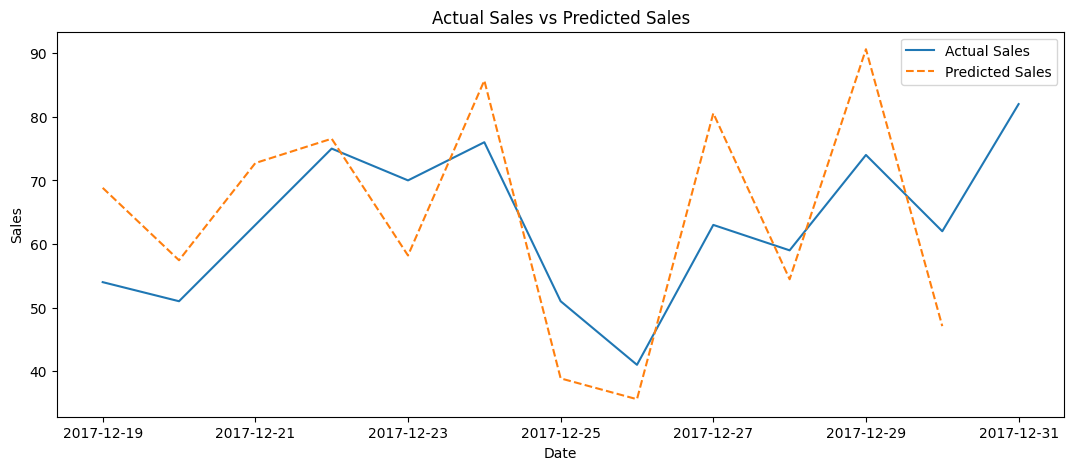

In [22]:
# Plotting actual sales vs predicted sales
plt.figure(figsize=(13, 5))
plt.plot(data.index[-13:], actual_sales, label='Actual Sales')
plt.plot(predict_df['date'], predict_df['linear_prediction'], label='Predicted Sales', linestyle='--')
plt.title('Actual Sales vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()